# Understanding the dataset

# The dataset provided for this competition is as follows

# 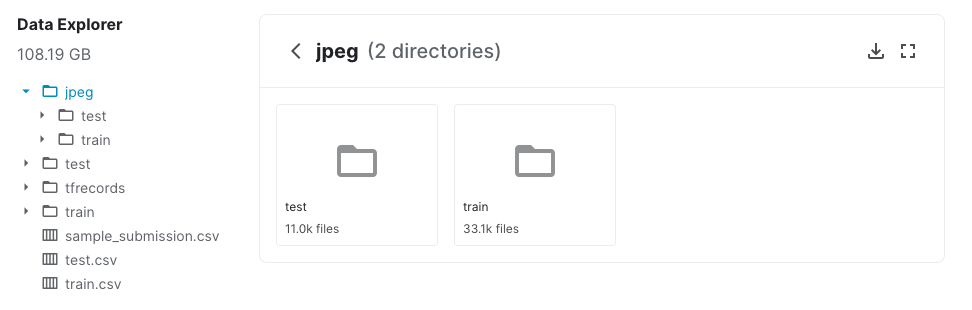

You can read more about the dataset
[here](http://https://www.kaggle.com/c/siim-isic-melanoma-classification/data)

Let us print the dataset 

In [ ]:
print("There are following directories and files in this dataset")
print(*list(os.listdir("../input/siim-isic-melanoma-classification")),sep = "\n")

# Choosing the data for model training

We will now count the number of images in the following directories:

1. jpeg -> train
2. train


In [ ]:
import glob
train_images_jpg_format = glob.glob('../input/siim-isic-melanoma-classification/jpeg/train/*.jpg')
len(train_images_jpg_format)

In [ ]:
import glob
train_images_dcm_format = glob.glob('../input/siim-isic-melanoma-classification/train/*.dcm')
len(train_images_dcm_format)

As we can see above the number of images in the DICOM format and JPEG format are same. So we will be using JPEG format images in this notebook for training and prediction purpose.

# We will use JPEG format of images and treat this problem as an image classification problem with 2 cateories.

# Importing necessary libraries


Import Pandas - For data analysis
Import Fastai - For training of deep learning model and predictions.

**Note**: We are using Fastai version 2 (Not previous version of Fastai- which is version 1).


In [ ]:
import pandas as pd

import fastai
from fastai.vision.all import *

# Defining the variables and assigning the paths for this notebook


In [ ]:
path = Path('../input/input/siim-isic-melanoma-classification/')
image_path = Path('../input/siim-isic-melanoma-classification/jpeg/train')
training_data_file = Path('../input/siim-isic-melanoma-classification/train.csv')
sample_submission_file = Path('../input/siim-isic-melanoma-classification/sample_submission.csv')

# Analysing the data

In [ ]:
train_df = pd.read_csv(training_data_file)

In [ ]:
print("Size of Training data \n", train_df.shape)
print("----------------------------------------------------------")
print("\nFirst few samples of data are \n",train_df.head())

Let us print the number of data samples with output as category "1"  

In [ ]:
train_df_output_1 = train_df[train_df['target']==1]
train_df_output_1.shape

Let us print the number of data samples with output as category "0"  

In [ ]:
train_df_output_0 = train_df[train_df['target']==0]
train_df_output_0.shape

# Selecting a subset of data for training purpose

We will select all the training data which has the output category as "1" and 0.3 % of training data which has the output category as "0" to have equal number of inputs with the same category of output.

In [ ]:
train_df_output_0 = train_df[train_df['target']==0].sample(frac=0.03,random_state=111)
train_df_output_0.shape

Let us join the inputs selected from both the categories and call it a "new_df".

In [ ]:
new_df = pd.concat([train_df_output_0,train_df_output_1]).reset_index(drop=True)
new_df.shape

# Creating the image data loader

In [ ]:
image_data_loader = ImageDataLoaders.from_df(new_df, path=image_path,
                               seed=42, fn_col=0, 
                               suff='.jpg', label_col=7, 
                               item_tfms=Resize(128), 
                               batch_tfms=aug_transforms(flip_vert=True, max_warp=0.), 
                               bs=128, val_bs=None, shuffle_train=True)

Let us check the device type of our "ImageDataLoader" to make sure that we are using "GPU" 

In [ ]:
image_data_loader.device

Let us check few random images from our ImageDataLoader's batch to make sure that images and labels appears correctly in it.

In [ ]:
image_data_loader.show_batch()


# Trainnig the image recognizer model

We create a CNN (convolutional neural network) with the following specific details:

* What data we want to train it on?
</br>
  Our data to be used for training is "image_data_loader"
  
* Which architecture to use?
</br>
  We are using Resnet34 
  
* what metric to use for our training evaluation?
  </br>
  We have specified it as "error_rate"

In [ ]:
learn = cnn_learner(image_data_loader, resnet34, metrics=error_rate)

Let us train the model for 4 epochs

In [ ]:
learn.fine_tune(2)

In [ ]:
sub = pd.read_csv(sample_submission_file)
sub.head()

In [ ]:
for i in range(10982):
    x = sub.at[i,'image_name']
    test_image = Path("../input/siim-isic-melanoma-classification/jpeg/test/" + x + ".jpg")
    pr1,_,pr2 = learn.predict(test_image)
    sub.at[i,'target'] = float(pr2[int(pr1)])

In [ ]:
sub.head()


In [ ]:
sub.to_csv('my_submission_file.csv', index=False)